<img width="800px" src="../images/img/001.png"></img>
# NOM DU PROJET: **Application mobile d'aide à la conduite  de reconnaissance des panneau de circulation routiere**
## <!-- TITLE -->Etape 1:  Analyse et préparation des jeux de données
<!--Auteur : Tchotaneu Ngatcha Giresse (INSTITUTE FRANCOPHONE INTERNATIONAL) -->

lien de telechargement : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

### Ce que nous allons realiser:

 - Comprendre le jeu de données
 - Préparation et mise en forme ou traitementent eventuel des données 
 - Enregistrer les ensembles de données améliorés dans un format de fichier que nous avons choisr "h5"

## 1: preparation de l'environement de travail (importation des bibiotheque utiles )

In [1]:
import os, time, sys
import csv
import math, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform

from importlib import reload

sys.path.append('..')
import mesFonctionsPersonnelles.fonctionDeBase as projet

datasets_dir = projet.init('GTSRB')

<br>**Projet de reconnaissance de forme**

Version              : 2.0.35
Notebook id          : GTSRB
Run time             : Wednesday 26 October 2022, 12:23:49
Hostname             : DESKTOP-36O6V1H (Windows)
Tensorflow log level : Info + Warning + Error  (=0)
Datasets dir         : C:\Users\TCHOTANEU\LesProjetsGiresse\datasets
Run dir              : ./run
Update keras cache   : False
tensorflow           : 2.9.1
numpy                : 1.23.2
sklearn              : 1.1.2
skimage              : 0.19.3
matplotlib           : 3.5.3
pandas               : 1.4.3


## 2 - Definition de quelques parametres
Vous pouvez choisir d'effectuer des tests ou de générer l'ensemble des données améliorées en définissant les paramètres suivants :  
###### -`portion` : 0.2  le pourcentage de donnees dans le dataset  que nous allons choisir 
###### -`output_dir` : repectoire où écrire l'ensemble des dataset amélioré 
###### -`./data`: dataset pour le test . 


In [2]:
Portion  = 1 # portion egale a 1 signifie que nous avons utilise l'enseble du dataset  
output_dir = './data' # repectoire ou nous allons stocker nos dataset fabriqué
progress_verbosity = 1 # affichage de la barre de progression 

In [3]:
projet.override('Portion', 'output_dir', 'progress_verbosity')

## 3 - Lecture du Dataset 
une description peut etre sur leur plateforme : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset
 -Chaque répertoire contient un fichier CSV avec les annotations : `GT-<ClassID>.csv` et les images d'entraînement.
 -les attributs du fichers CSV: `Filename ; Width ; Height ; Roi.X1 ; Roi.Y1 ; Roi.X2 ; Roi.Y2 ; ClassId`

nous avons trois sous dossier  : **Train**, **Test** and **Meta.**  
chaque sous dossier a un fichier  **csv ** avec les **images**.
    

In [4]:
df = pd.read_csv(f'{datasets_dir}/GTSRB/origine/Test.csv', header=0)
display(df.head(10))

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png
5,52,56,5,5,47,51,38,Test/00005.png
6,147,130,12,12,135,119,18,Test/00006.png
7,32,33,5,5,26,28,12,Test/00007.png
8,45,50,6,5,40,45,25,Test/00008.png
9,81,86,7,7,74,79,35,Test/00009.png


### definition d'une fonction utile pour la lecture des image a partir des fichiers CSV:

In [5]:
def  read_csv_dataset(csv_file): 
    
    path = os.path.dirname(csv_file)
    name = os.path.basename(csv_file)

    # ---- lecture du fichier csv 
    df = pd.read_csv(csv_file, header=0)
    
    # ---- lectures de classes 
    filenames = df['Path'].to_list()
    y         = df['ClassId'].to_list()
    x         = []
    
    # ---- lecture des immage
    
    for filename in filenames:
        image=io.imread(f'{path}/{filename}')
        x.append(image)
        projet.update_progress(name,len(x),len(filenames), verbosity=progress_verbosity)
    
    return np.array(x,dtype=object),np.array(y)

### Lecture du dataset 
Nous allons lire les ensembles de données suivants :
 ##### - Sous-ensemble **Train**, pour les données d'apprentissage comme :  `x_train, y_train`
 ##### - Sous-ensemble **Test**, pour les données de validation comme :  `x_test, y_test`
 ##### - Sous-ensemble **Meta**, pour la visualisation des panneau dans leur etat d'origine  : `x_meta, y_meta`

In [6]:
projet.chrono_start()

# ---- lectures de dataset 

(x_train,y_train) = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Train.csv')
(x_test ,y_test)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Test.csv')
(x_meta ,y_meta)  = read_csv_dataset(f'{datasets_dir}/GTSRB/origine/Meta.csv')
    
# ---- melange des donnees d'entrainement 

x_train, y_train = projet.shuffle_np_dataset(x_train, y_train)

# ---- 

combined = list(zip(x_meta,y_meta))
combined.sort(key=lambda x: x[1])
x_meta,y_meta = zip(*combined)

projet.chrono_show()

Train.csv        [########################################] 100.0% of 39209
Test.csv         [########################################] 100.0% of 12630
Meta.csv         [########################################] 100.0% of 43

Duration :  00:00:32 641ms


##  4 -un peu de statistiques sur le jeu de données 
 juste pour savoir l'homogenité  des  images en termes  de quantité, de ratio, de largeur ou de hauteur.

In [9]:
train_size  = []
train_ratio = []
train_lx    = []
train_ly    = []

test_size   = []
test_ratio  = []
test_lx     = []
test_ly     = []

for image in x_train:
    (lx,ly,lz) = image.shape
    train_size.append(lx*ly/1024)
    train_ratio.append(lx/ly)
    train_lx.append(lx)
    train_ly.append(ly)

for image in x_test:
    (lx,ly,lz) = image.shape
    test_size.append(lx*ly/1024)
    test_ratio.append(lx/ly)
    test_lx.append(lx)
    test_ly.append(ly)
print(image.shape)

(31, 32, 3)


x_train shape :  (39209,)
y_train shape :  (39209,)
x_test  shape :  (12630,)
y_test  shape :  (12630,)


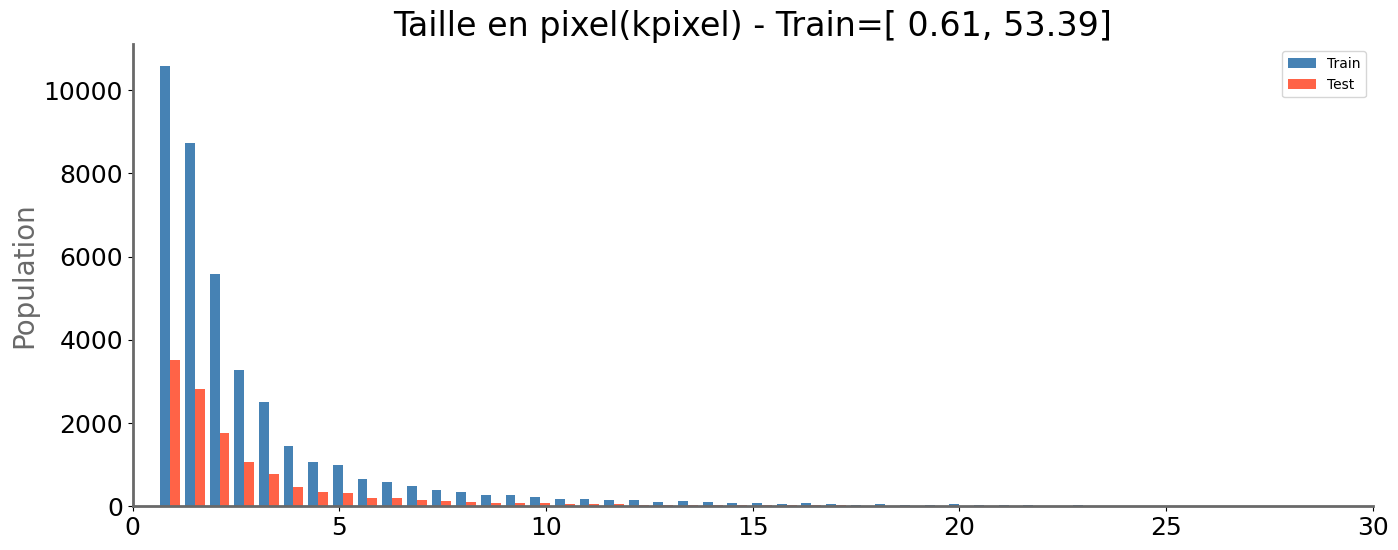

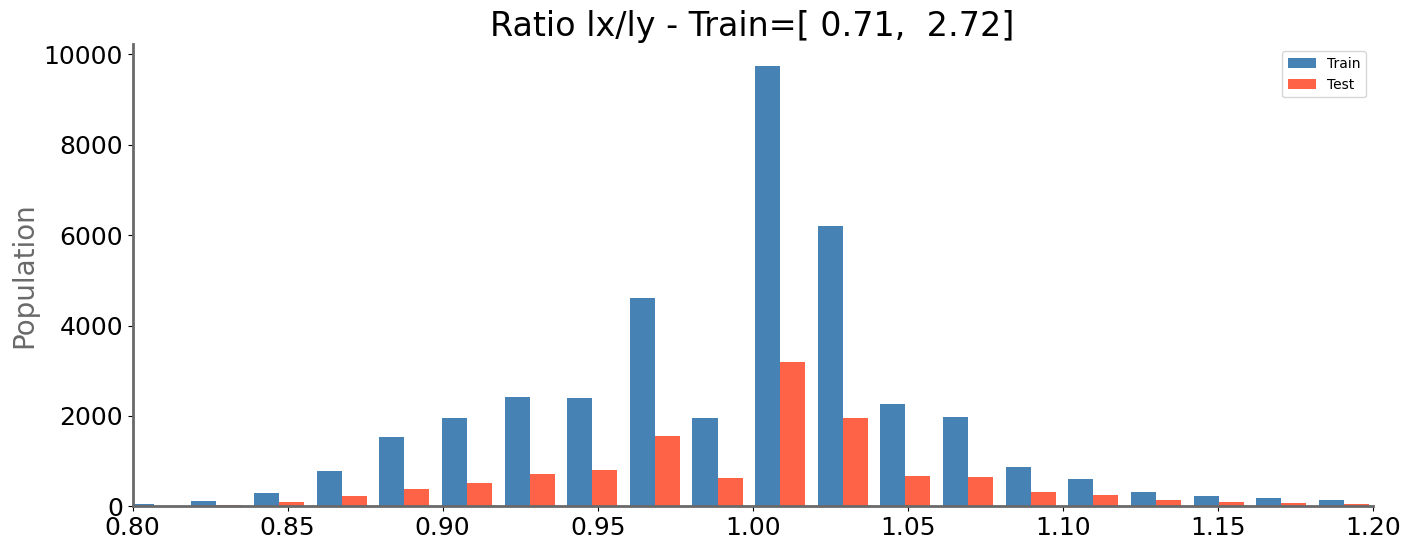

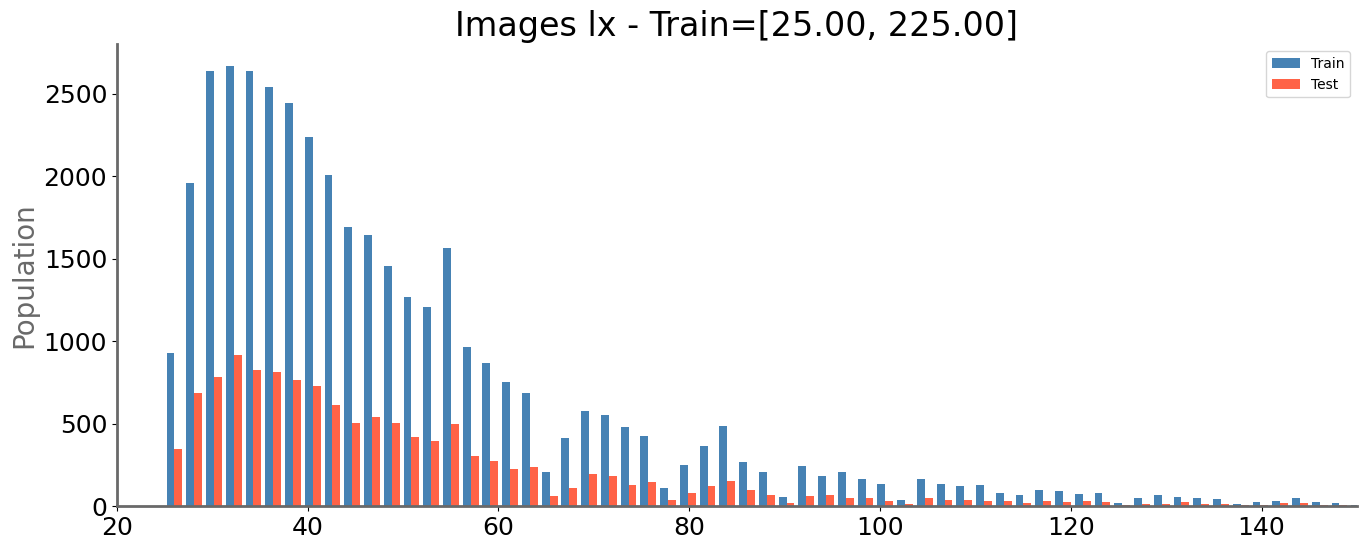

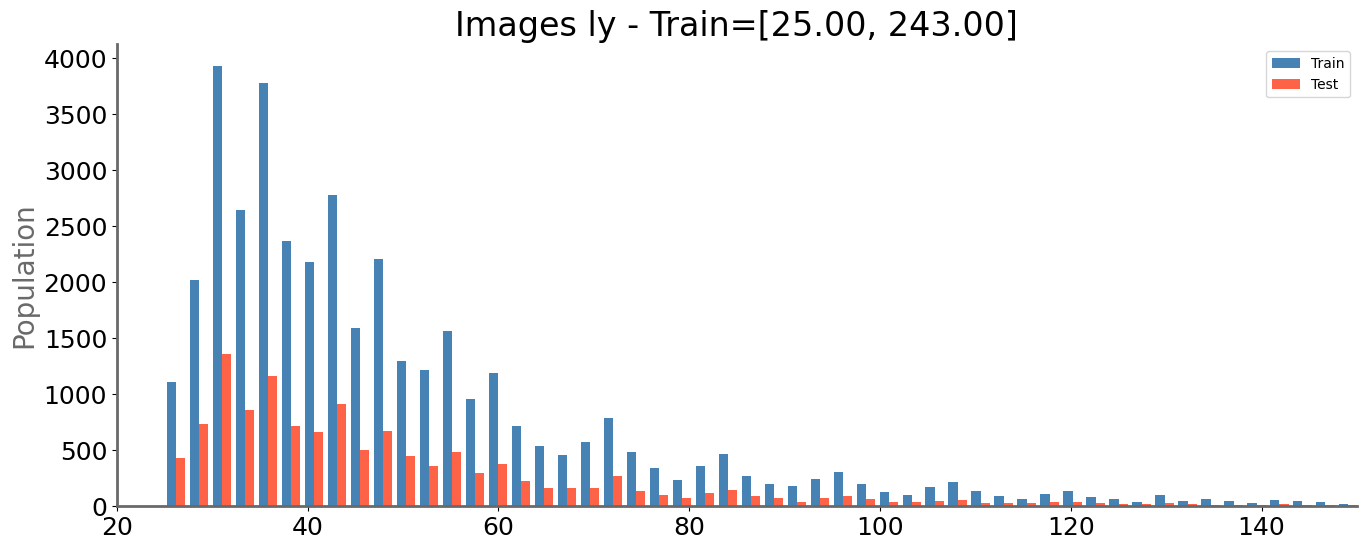

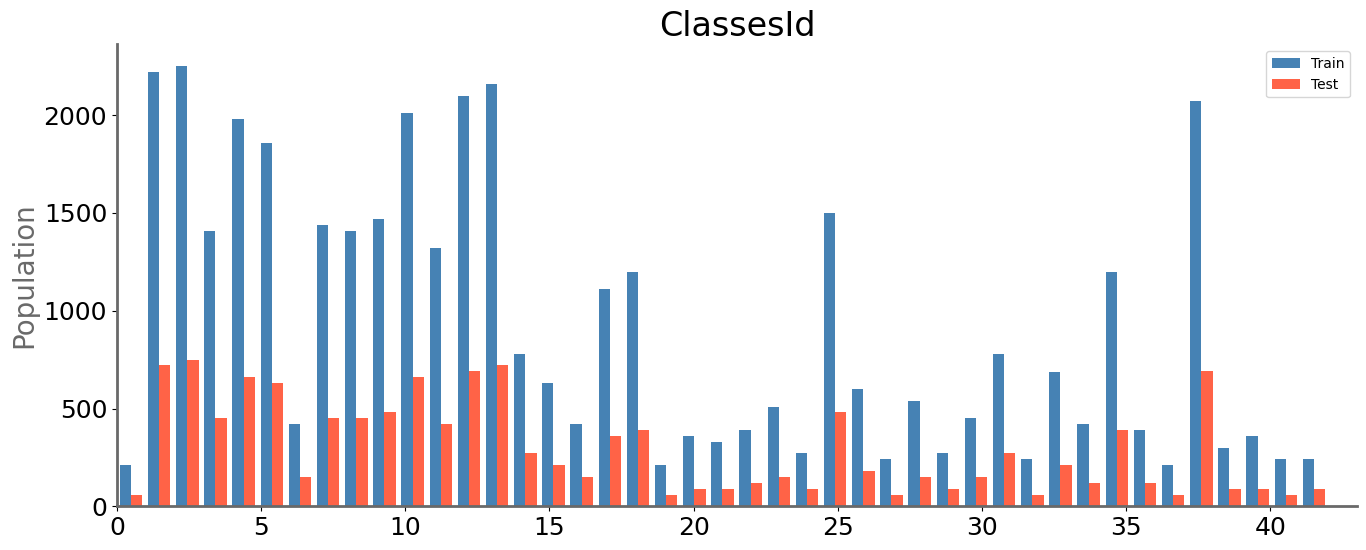

In [10]:
# -
print("x_train shape : ",x_train.shape)
print("y_train shape : ",y_train.shape)
print("x_test  shape : ",x_test.shape)
print("y_test  shape : ",y_test.shape)

# ------ stat de la taille 
plt.figure(figsize=(16,6))
plt.hist([train_size,test_size], bins=100)
plt.gca().set(title='Taille en pixel(kpixel) - Train=[{:5.2f}, {:5.2f}]'.format(min(train_size),max(train_size)), 
              ylabel='Population', xlim=[0,30])
plt.legend(['Train','Test'])
projet.save_fig('01-stats-sizes')
plt.show()

# ------ Stat ratio 
plt.figure(figsize=(16,6))
plt.hist([train_ratio,test_ratio], bins=100)
plt.gca().set(title='Ratio lx/ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ratio),max(train_ratio)), 
              ylabel='Population', xlim=[0.8,1.2])
plt.legend(['Train','Test'])
projet.save_fig('02-stats-ratios')
plt.show()

# ------ Statist lx
plt.figure(figsize=(16,6))
plt.hist([train_lx,test_lx], bins=100)
plt.gca().set(title='Images lx - Train=[{:5.2f}, {:5.2f}]'.format(min(train_lx),max(train_lx)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
projet.save_fig('03-stats-lx')
plt.show()

# ------ Stat / ly
plt.figure(figsize=(16,6))
plt.hist([train_ly,test_ly], bins=100)
plt.gca().set(title='Images ly - Train=[{:5.2f}, {:5.2f}]'.format(min(train_ly),max(train_ly)), 
              ylabel='Population', xlim=[20,150])
plt.legend(['Train','Test'])
projet.save_fig('04-stats-ly')
plt.show()

# ------ Statistics / classId
plt.figure(figsize=(16,6))
plt.hist([y_train,y_test], bins=43)
plt.gca().set(title='ClassesId', ylabel='Population', xlim=[0,43])
plt.legend(['Train','Test'])
projet.save_fig('05-stats-classes')
plt.show()

## 5 -liste des classes 

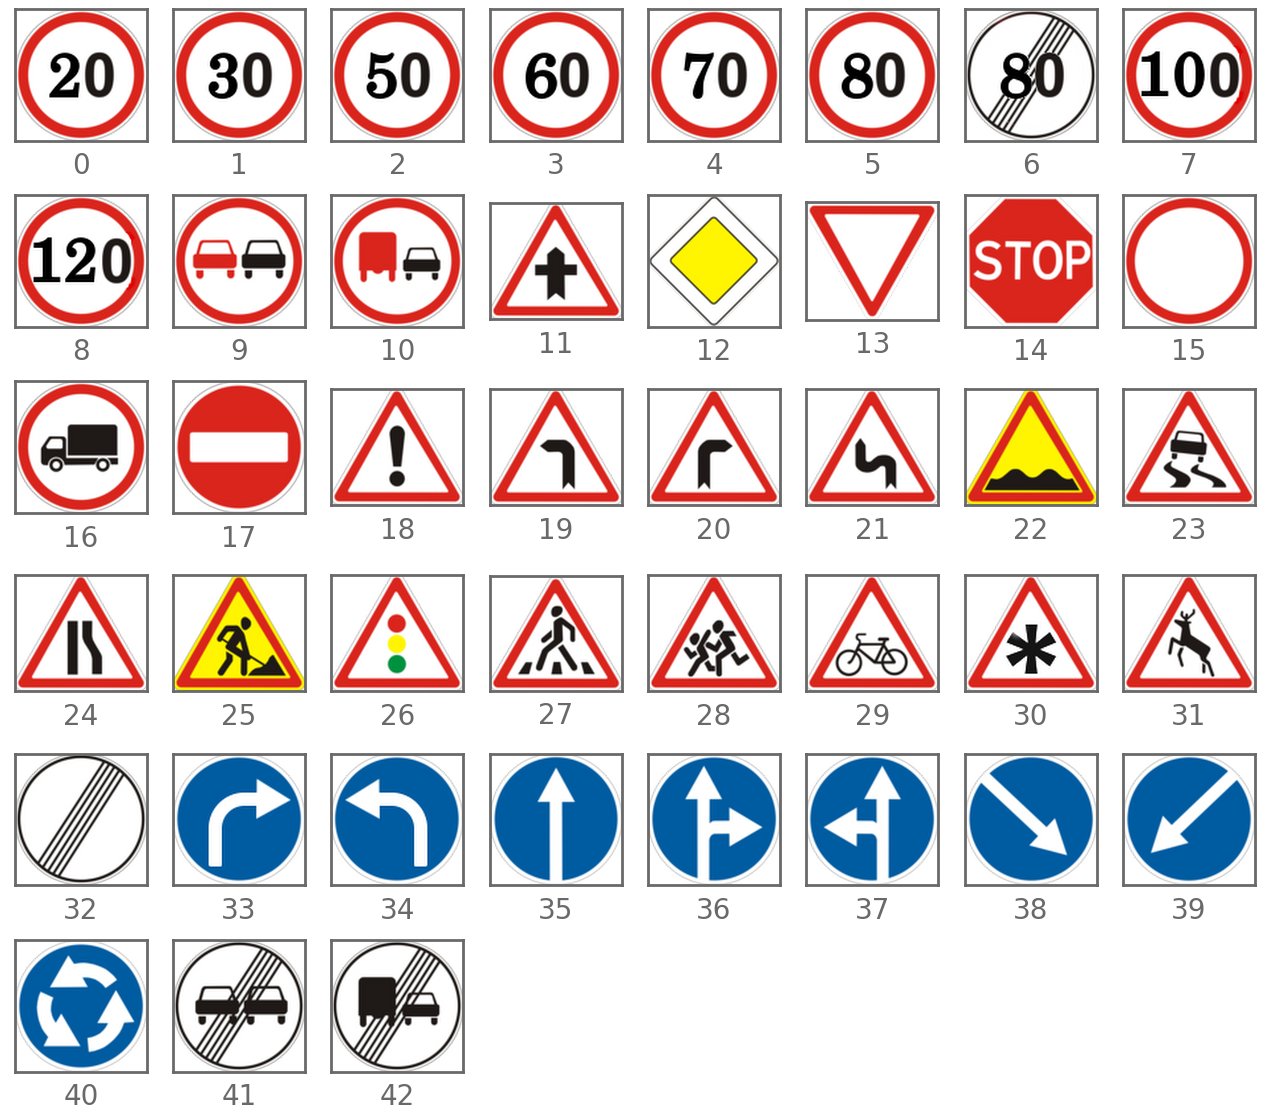

In [12]:
projet.plot_images(x_meta,y_meta, range(43), columns=8, x_size=2, y_size=2, 
                                colorbar=False, y_pred=None, cm='binary', save_as='06-meta-signs')

##  6 - affichage des panneaux dans la realité

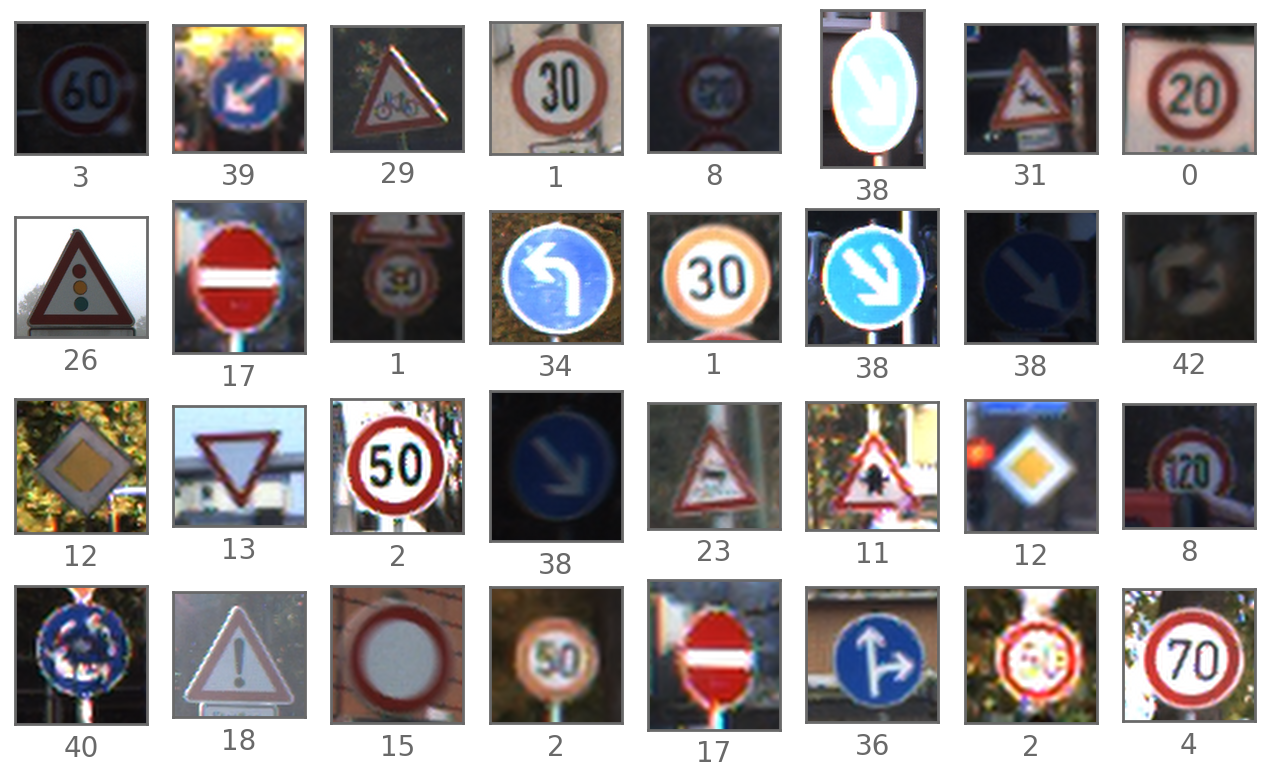

In [13]:
exemple = [ random.randint(0,len(x_train)-1) for i in range(32)]
projet.plot_images(x_train,y_train, exemple , columns=8, x_size=2, y_size=2, 
                colorbar=False, y_pred=None, cm='binary', save_as='07-real-signs')


## 7 - traitement de données sur le dataset 
Les images **doivent** :
 - avoir la **même taille** pour correspondre à la taille du réseau,
 - être **normalisées**.  
 nous allons travailler avec  des donnees  en 
 #### -images **rgb**
 #### -images **monochromes** 
 #### - images en  **égaliser les histogrammes**  

In [17]:
def images_enhancement(images, width=25, height=25, mode='RGB'):
   
    modes = { 'RGB':3, 'RGB-HE':3, 'L':1, 'L-HE':1, 'L-LHE':1, 'L-CLAHE':1}
    lz=modes[mode]
    
    out=[]
    for img in images:
        
        # ----si RGBA, convertir en  RGB
        if img.shape[2]==4:
            img=color.rgba2rgb(img)
            
        # ---- redimensionner la taille de l'image 
        img = transform.resize(img, (width,height))

        # ---- RGB avec Histogram Equalization
        if mode=='RGB-HE':
            hsv = color.rgb2hsv(img.reshape(width,height,3))
            hsv[:, :, 2] = exposure.equalize_hist(hsv[:, :, 2])
            img = color.hsv2rgb(hsv)
        
        # ---- niveau de gris 
        if mode=='L':
            img=color.rgb2gray(img)
            
        # ---- niveau de gris  /egalisation d'histogramme
        if mode=='L-HE':
            img=color.rgb2gray(img)
            img=exposure.equalize_hist(img)
            
        # ---- niveau de gris / egalisation d'histogramme locale 
        if mode=='L-LHE':        
            img=color.rgb2gray(img)
            img = img_as_ubyte(img)
            img=rank.equalize(img, disk(10))/255.
        
        # ---- niveau de gris  / contract adapte à l'equalisation d'histogramme (CLAHE)
        if mode=='L-CLAHE':
            img=color.rgb2gray(img)
            img=exposure.equalize_adapthist(img)
            
        # ---- 
        out.append(img)
        projet.update_progress('Enhancement: ',len(out),len(images))

    out = np.array(out,dtype='float64')
    out = out.reshape(-1,width,height,lz) 
    return out

###  affichage des dataset ameliorés 

Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16
Enhancement:     [################] 100.0% of 16


<br>**visualisation des Meta**

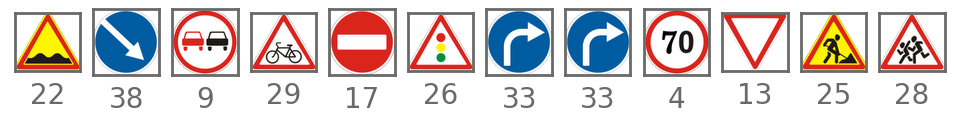

<br>**visualisation originale**

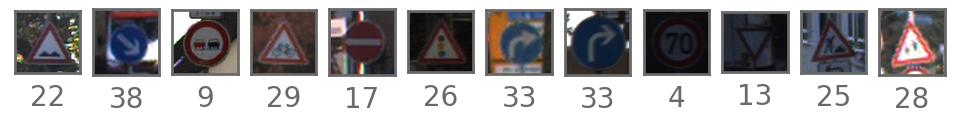

<br>**dataset ameliorées**

dataset : RGB  min,max=[0.032,1.000]  shape=(16, 25, 25, 3)


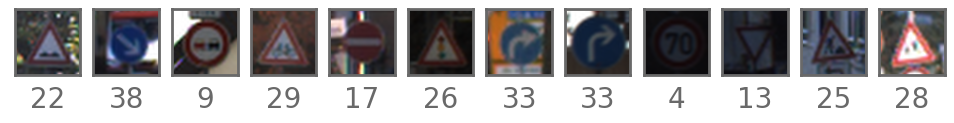

dataset : RGB-HE  min,max=[0.001,1.000]  shape=(16, 25, 25, 3)


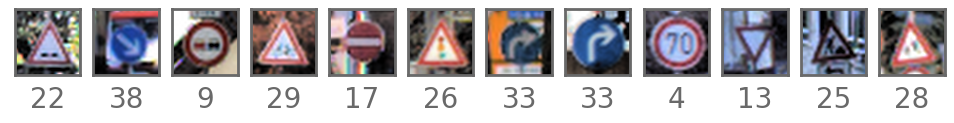

dataset : L  min,max=[0.033,1.000]  shape=(16, 25, 25, 1)


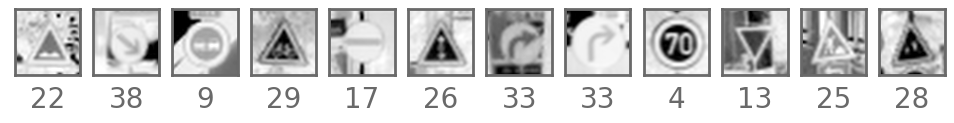

dataset : L-HE  min,max=[0.002,1.000]  shape=(16, 25, 25, 1)


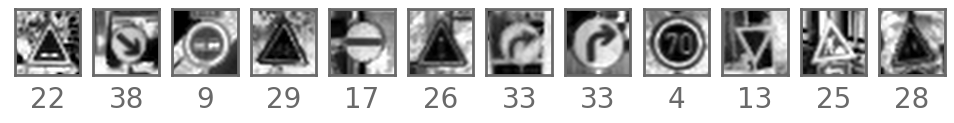

dataset : L-LHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


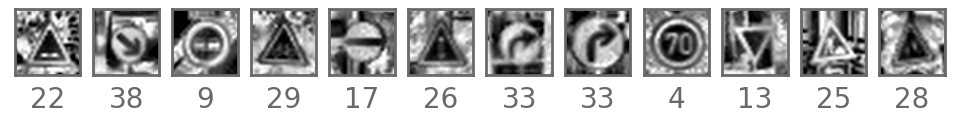

dataset : L-CLAHE  min,max=[0.000,1.000]  shape=(16, 25, 25, 1)


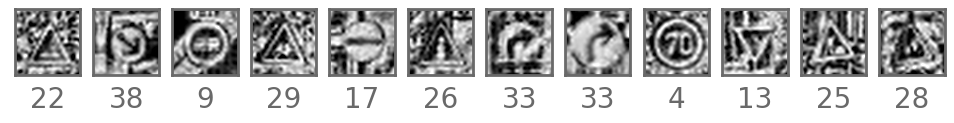

In [18]:
i=random.randint(0,len(x_train)-16)
x_samples = x_train[i:i+16]
y_samples = y_train[i:i+16]

datasets  = {}

datasets['RGB']      = images_enhancement( x_samples, width=25, height=25, mode='RGB'  )
datasets['RGB-HE']   = images_enhancement( x_samples, width=25, height=25, mode='RGB-HE'  )
datasets['L']        = images_enhancement( x_samples, width=25, height=25, mode='L'  )
datasets['L-HE']     = images_enhancement( x_samples, width=25, height=25, mode='L-HE'  )
datasets['L-LHE']    = images_enhancement( x_samples, width=25, height=25, mode='L-LHE'  )
datasets['L-CLAHE']  = images_enhancement( x_samples, width=25, height=25, mode='L-CLAHE'  )

projet.subtitle('visualisation des Meta')
x_expected=[ x_meta[i] for i in y_samples]
projet.plot_images(x_expected, y_samples, range(12), columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', save_as='08-expected')

projet.subtitle('visualisation originale')
projet.plot_images(x_samples,  y_samples, range(12), columns=12, x_size=1, y_size=1, 
                colorbar=False, y_pred=None, cm='binary', save_as='09-original')

projet.subtitle('dataset ameliorées')
n=10
for k,d in datasets.items():
    print("dataset : {}  min,max=[{:.3f},{:.3f}]  shape={}".format(k,d.min(),d.max(), d.shape))
    projet.plot_images(d, y_samples, range(12), columns=12, x_size=1, y_size=1, 
                    colorbar=False, y_pred=None, cm='binary', save_as=f'{n}-enhanced-{k}')
    n+=1


### sauvegarde 


In [19]:
def save_h5_dataset(x_train, y_train, x_test, y_test, x_meta,y_meta, filename):
        
    # ---- Create h5 file
    with h5py.File(filename, "w") as f:
        f.create_dataset("x_train", data=x_train)
        f.create_dataset("y_train", data=y_train)
        f.create_dataset("x_test",  data=x_test)
        f.create_dataset("y_test",  data=y_test)
        f.create_dataset("x_meta",  data=x_meta)
        f.create_dataset("y_meta",  data=y_meta)
        
    # ---- done
    size=os.path.getsize(filename)/(1024*1024)
    print('Dataset : {:24s}  shape : {:22s} size : {:6.1f} Mo   (saved)'.format(filename, str(x_train.shape),size))

In [21]:
projet.chrono_start()

n_train = int( len(x_train)*Portion )
n_test  = int( len(x_test)*Portion )

projet.subtitle('Parametres :')
print(f'Pourcentage_Dataset : {Portion  }')
print(f'x_train taille est de  : {n_train}')
print(f'x_test taille est de : {n_test}')
print(f'Repectoire de stockage   : {output_dir}\n')

projet.subtitle('Running...')

projet.mkdir(output_dir)

for s in [24, 48]:
    for m in ['RGB', 'RGB-HE', 'L', 'L-LHE']:
        # ---- 
        filename = f'{output_dir}/set-{s}x{s}-{m}.h5'
        projet.subtitle(f'Dataset : {filename}')
        
   
        x_train_new = images_enhancement( x_train[:n_train], width=s, height=s, mode=m )
        x_test_new  = images_enhancement( x_test[:n_test],  width=s, height=s, mode=m )
        x_meta_new  = images_enhancement( x_meta,  width=s, height=s, mode='RGB' )
        
        # ---- Sauvegarde
        save_h5_dataset( x_train_new, y_train[:n_train], x_test_new, y_test[:n_test], x_meta_new,y_meta, filename)

x_train_new,x_test_new=0,0

projet.chrono_show()

<br>**Parametres :**

Pourcentage_Dataset : 1
x_train taille est de  : 39209
x_test taille est de : 12630
Repectoire de stockage   : ./data



<br>**Running...**

<br>**Dataset : ./data/set-24x24-RGB.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB.h5   shape : (39209, 24, 24, 3)     size :  684.2 Mo   (saved)


<br>**Dataset : ./data/set-24x24-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-RGB-HE.h5  shape : (39209, 24, 24, 3)     size :  684.2 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L.h5     shape : (39209, 24, 24, 1)     size :  228.6 Mo   (saved)


<br>**Dataset : ./data/set-24x24-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-24x24-L-LHE.h5  shape : (39209, 24, 24, 1)     size :  228.6 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB.h5   shape : (39209, 48, 48, 3)     size : 2736.2 Mo   (saved)


<br>**Dataset : ./data/set-48x48-RGB-HE.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-RGB-HE.h5  shape : (39209, 48, 48, 3)     size : 2736.2 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L.h5     shape : (39209, 48, 48, 1)     size :  913.7 Mo   (saved)


<br>**Dataset : ./data/set-48x48-L-LHE.h5**

Enhancement:     [########################################] 100.0% of 39209
Enhancement:     [########################################] 100.0% of 12630
Enhancement:     [########################################] 100.0% of 43
Dataset : ./data/set-48x48-L-LHE.h5  shape : (39209, 48, 48, 1)     size :  913.7 Mo   (saved)

Duration :  00:09:10 188ms


## - affichons les données pour verification 

dataset loaded from h5 file.


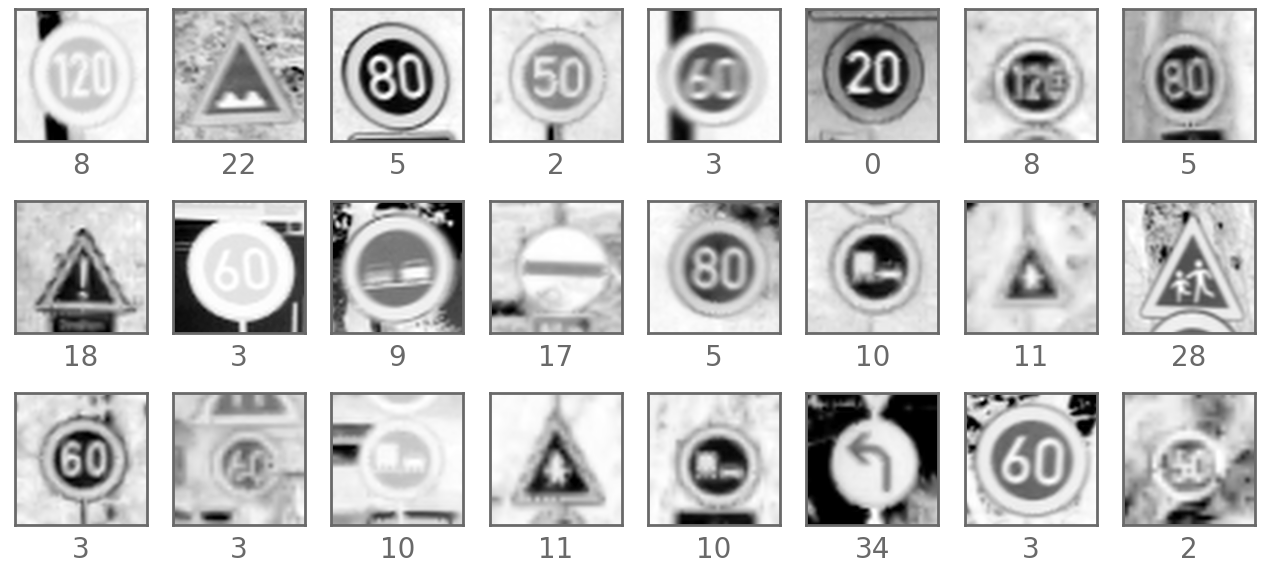


Duration :  00:00:02 505ms


In [22]:
projet.chrono_start()

dataset='set-48x48-L'
samples=range(24)

with  h5py.File(f'{output_dir}/{dataset}.h5','r') as f:
    x_tmp = f['x_train'][:]
    y_tmp = f['y_train'][:]
    print("dataset loaded from h5 file.")

projet.plot_images(x_tmp,y_tmp, samples, columns=8, x_size=2, y_size=2, 
                colorbar=False, y_pred=None, cm='binary', save_as='16-enhanced_images')
x_tmp,y_tmp=0,0

projet.chrono_show()

In [23]:
projet.end()

**Fin du traitement :** Wednesday 26 October 2022, 12:45:16  
**Durée :** 00:21:27 525ms  
Notre notebook se termine ici ,le code est disponible sur  :-)  
[https://github.com/tchotaneu](https://github.com/tchotaneu)